## Reference

Custom Dataset classes in pytorch
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


Calculating mean and std of custom Dataset

https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/3

https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560

https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7


## Library imports

In [1]:
# common imports
import os
import random
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
#import math
#import time
#from skimage import io, transform
#from typing import Dict
#from pathlib import Path
import cv2

# interactive plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
#from plotly.offline import init_notebook_mode, iplot # download_plotlyjs, plot
#import plotly.graph_objs as go
#from plotly.subplots import make_subplots
#init_notebook_mode(connected=True)

# torch imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
import torch.nn.functional as F


# sklearn related imports
# import skorch #sklearn + pytorch functionalitites
from sklearn.model_selection import StratifiedKFold #KFold, 
#from sklearn.model_selection import cross_val_score

#import skorch
#from skorch.callbacks import Checkpoint
#from skorch.callbacks import Freezer
#from skorch.helper import predefined_split
#from skorch import NeuralNetClassifier

## Config files

In [2]:
path_cfg = {'train_img_path': "cassava-leaf-disease-classification/train_images/",
            'train_csv_path': 'cassava-leaf-disease-classification/train.csv',
            'train' : True, 'lr_find' : False, 'validate' : True, 'test' : False}

model_cfg = {'model_architecture': 'resnet18', 'model_name': 'R18_imagenet',
             'init_lr': 1e-4, 'weight_path': '', 'train_epochs':5}

train_cfg = {'batch_size': 256, 'shuffle': False, 'num_workers': 4, 'checkpt_every' : 1 }
valid_cfg = {'batch_size': 16, 'shuffle': False, 'num_workers': 4, 'validate_every' : 1 }
test_cfg  = {'batch_size': 16, 'shuffle': False, 'num_workers': 4}

In [3]:
index_label_map = {
                0: "Cassava Bacterial Blight (CBB)", 
                1: "Cassava Brown Streak Disease (CBSD)",
                2: "Cassava Green Mottle (CGM)", 
                3: "Cassava Mosaic Disease (CMD)", 
                4: "Healthy"
                }

## EDA

In [4]:
DIR_INPUT = 'cassava-leaf-disease-classification'

In [5]:
train_csv = pd.read_csv('cassava-leaf-disease-classification/train.csv')
train_csv['disease'] = train_csv['label'].map(index_label_map);
train_csv['npy_image_id'] = train_csv['image_id'].str.replace('jpg', 'npy')
print(train_csv.shape)
train_csv.head()

(21397, 4)


,image_id,label,disease,npy_image_id
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),1000015157.npy
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),1000201771.npy
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),100042118.npy
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),1000723321.npy
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),1000812911.npy


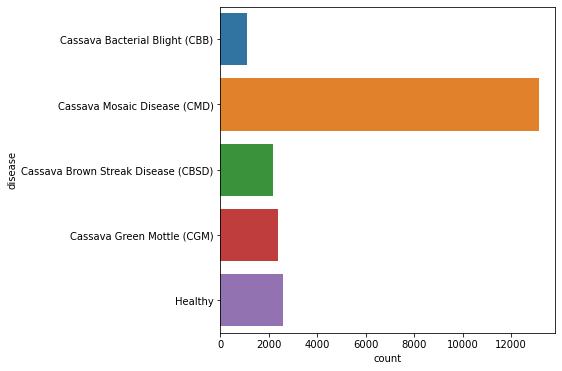

In [6]:
_, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(y='disease', data=train_csv, ax=axes);

In [7]:
print(train_csv['disease'].value_counts(normalize=True))

Cassava Mosaic Disease (CMD)           0.614946
Healthy                                0.120437
Cassava Green Mottle (CGM)             0.111511
Cassava Brown Streak Disease (CBSD)    0.102304
Cassava Bacterial Blight (CBB)         0.050802
Name: disease, dtype: float64


## Helper functions

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
RANDOM_STATE = 42
set_seed(RANDOM_STATE)

## Converting jpg to npy format

In [9]:
#NPY_FOLDER = '/media/wabco/Seagate Expansion Drive/surya/sdxc/Git repos/Cassava leaf diesease detection/train_npy_images'
NPY_FOLDER = 'cassava-leaf-disease-classification/train_npy_images'

In [10]:
%%time
for idx in range(0, len(train_csv)):
#for idx in range(0, 1000):
    image_src = f'{DIR_INPUT}/train_images/{train_csv.loc[idx, "image_id"]}'
    image = cv2.imread(image_src, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    np.save(f'{NPY_FOLDER}/{train_csv.loc[idx, "npy_image_id"]}', image)
    if idx % 1000 == 0:
        print(str(idx) + ' images saved')
    #np_image = np.load(f'{NPY_FOLDER}/{train_csv.loc[idx, "npy_image_id"]}')

0 images saved
1000 images saved
2000 images saved
3000 images saved
4000 images saved
5000 images saved
6000 images saved
7000 images saved
8000 images saved
9000 images saved
10000 images saved
11000 images saved
12000 images saved
13000 images saved
14000 images saved
15000 images saved
16000 images saved
17000 images saved
18000 images saved
19000 images saved
20000 images saved
21000 images saved
CPU times: user 4min 55s, sys: 1min 11s, total: 6min 7s
Wall time: 6min 59s


1. 1000 images, cv2 read - CPU : user=11.2s, sys=1.08s, wall time 7.54 seconds
2. 1000 images, npy read - CPU : user=357 ms, sys=205ms, wall time 562 milliseconds

In [11]:
import glob
import os

In [18]:
cv2_folder_path = '/home/wabco/Downloads/sdxc/Git repos/Cassava_leaf_disease_kaggle/cassava-leaf-disease-classification/train_images/'
npy_folder_path = '/home/wabco/Downloads/sdxc/Git repos/Cassava_leaf_disease_kaggle/cassava-leaf-disease-classification/train_npy_images/'

In [19]:
os.chdir(cv2_folder_path)
cv2_image_list = [i for i in glob.glob('*.jpg')]
cv2_image_list = [i.rstrip('.jpg') for i in cv2_image_list]

In [23]:
print(len(cv2_image_list))
#cv2_image_list[0]

21397


In [26]:
os.chdir(npy_folder_path)
npy_list = [i for i in glob.glob('*.npy')]
npy_list = [i.rstrip('.npy') for i in npy_list]

In [27]:
print(len(npy_list))
npy_list[0]

21397


'2253776549'

In [28]:
set(npy_list) - set(cv2_image_list)

set()

In [29]:
len(list(set(npy_list).intersection(set(cv2_image_list))))

21397

In [49]:
from sys import getsizeof

In [50]:
getsizeof(image)

1440128

In [51]:
np_image = np.load(f'{NPY_FOLDER}/{train_csv.loc[idx, "npy_image_id"]}')

In [52]:
getsizeof(np_image)

1440128

In [39]:
image = image.astype(int)

In [28]:
np.save('test.npy', image)

In [22]:
type(image)

numpy.ndarray

In [23]:
image[0][0][0]

33

In [25]:
21800 * 0.13 / 1000

2.834

In [26]:
21800 * 1.3 /1000

28.34

In [28]:
def cv2_img_to_npy(df, write_folder):
    
    
    for in in range(len(df)):
    

CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 42.1 ms


In [31]:
type(image)

numpy.ndarray

In [34]:
image.shape

(600, 800, 3)

In [36]:
%%time


CPU times: user 0 ns, sys: 4.46 ms, total: 4.46 ms
Wall time: 9.49 ms


In [37]:
np_image.shape

(600, 800, 3)

## Dataset class

In [27]:
class CassavaDataset(Dataset):
    
    def __init__(self, df, dataset='train', transforms=None):
        self.df = df
        self.transforms=transforms
        self.dataset=dataset
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):        
        image_src = f'{DIR_INPUT}/{self.dataset}_images/{self.df.loc[idx, "image_id"]}'
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.dataset == 'train':
            labels = self.df.loc[idx, ['cls0', 'cls1', 'cls2', 'cls3', 'cls4']].values
            labels = torch.from_numpy(labels.astype(np.int8))
            labels = labels.unsqueeze(-1)
        
        else:
            labels = torch.Tensor(1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

## Device 

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

## Transforms and Dataloader

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

cassava_dataset = CassavaDataset(csv_file=path_cfg['train_csv_path'], root_dir=path_cfg['train_img_path'], 
                                 transform=transforms)

print(f'Length of total Dataset is ', {len(cassava_dataset)})

cassava_dataloader = DataLoader(cassava_dataset, batch_size=train_cfg['batch_size'],shuffle=train_cfg['shuffle'])

In [ ]:
pop_mean = []
pop_std0 = []
pop_std1 = []

In [ ]:
for idx, (data, _) in enumerate(cassava_dataloader):
    # shape (batch_size, 3, height, width)
    numpy_image = data.numpy()
    #print(numpy_image.shape)
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    if idx % 5 == 0 :
        print(idx)
        
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)

print(pop_mean, pop_std0, pop_std1)